### How to use this notebook (for anyone not familiar with jupyter)

Before we get started, I'd like to note that while reading this notebook on github is fine, there are several interactive elements used to demonstrate several ideas that only render when the notebook is ran in a live kernel. This also allows you to play with the code samples inline with the rest of the notebook.

For the best experience I'd recommend installing [jupyter](https://jupyter.org/install) on your machine and cloning this repository so that you can run the notebooks locally. 

If however you'd prefer not to install anything, you can also run this notebook on Google's Colab [here](https://colab.research.google.com/github/jd-13/dsp-math-for-audio/blob/master/02_Envelope-Followers.ipynb).

Once running click `Kernel` -> `Restart & Run All` (or `Runtime` -> `Run all` if you're using Colab) to render all of the interactive examples, and you are then free to edit the code and run individual cells as you wish.

In [1]:
# This cell contains imports, variables, and functions required by code later in the notebook

from ipywidgets import interact
import matplotlib.pylab as plt
import math
import numpy as np
import scipy.signal
%matplotlib inline

# We'll use this to define the x-axis of any graphs we plot
NUM_SAMPLES = 500
SAMPLE_RANGE = np.linspace(0, NUM_SAMPLES, NUM_SAMPLES)

# Run at a lower than usual sample rate to keep the interactive examples from
# needing too much compute
SAMPLE_RATE = 10000

Y_LIMIT = 1.2

def sineWaveDecay(frequencyHz):
    """
    Returns a np array of length numSamples containing a sine wave impulse
    which decays linearly.
    """    
    # Build a saw that is half the length of the buffer
    amplitudeMap = (-scipy.signal.sawtooth(0.5 * np.linspace(0, 4 * np.pi, int(NUM_SAMPLES / 2))) + 1) / 2
    
    # Concatenate zeros either side of the saw
    zerosQuarter = np.zeros((int(NUM_SAMPLES / 4)))
    amplitudeMap = np.concatenate((zerosQuarter, amplitudeMap, zerosQuarter))
    
    # Smooth the amplitude map
    b, a = scipy.signal.butter(4, 0.04, btype="lowpass", analog=False)
    amplitudeMap = scipy.signal.lfilter(b, a, amplitudeMap)
    
    # Produce the sine wave, modulating the amplitude using the saw wave
    buffer = np.sin((2 * math.pi * frequencyHz) * (SAMPLE_RANGE / SAMPLE_RATE)) * amplitudeMap
    
    return buffer

def genericPlotEnvelopeFollower(signalBuffer, envelopeOutput, titles):
    """
    Given an input signal and the outputs of an envelope follower function,
    generates the plots of these outputs.
    """
    # Scale the size depending on the number of plots
    plt.figure(figsize=(15, len(envelopeOutput) * 5))
    
    # Plot the threshold signal
    plt.subplot(2, 1, 1)
    plt.title(titles[0])
    plt.plot(SAMPLE_RANGE, envelopeOutput[0])
    plt.ylim(bottom=-Y_LIMIT, top=Y_LIMIT)
    plt.xlabel("Samples")
    plt.ylabel("Displacement")
    
    # Plot the input signal
    plt.subplot(2, 1, 2)
    plt.title(titles[1])
    plt.plot(SAMPLE_RANGE, signalBuffer)
    plt.ylim(bottom=-Y_LIMIT, top=Y_LIMIT)
    plt.xlabel("Samples")
    plt.ylabel("Displacement")
    
    # Plot the analytic signal
    plt.plot(SAMPLE_RANGE, envelopeOutput[1])
    
    plt.show()

## Intro

In this notebook we'll be looking at what envelope followers do, a little of the math around how they work, and finally how to implement them.

Let's start with what an envelope follower is: an envelope follower, or envelope detector, converts an audio signal into a signal which represents its amplitude over time. This new signal can then be used to drive other processes, for example controlling the cutoff frequency of a filter in an [effect pedal](https://www.youtube.com/watch?v=LNFc3Mub4N4).

Note that this is different to an envelope *generator* (such as an ADSR envelope), which creates an envelope that can then be applied to a signal.

The below code sample demonstrates how an envelope follower works using functions provided for us by the scipy package. Run the code and the output will be drawn inline below it.

In [2]:
@interact(frequency=(50, 1000, 100))
def demoEnvelope(frequency):
    """
    Plots an input signal and an example envelope of the signal.
    """

    # Generate the input signal
    buffer = sineWaveDecay(frequency)

    plt.figure(figsize=(15, 4))
    
    # Plot the input signal
    plt.plot(SAMPLE_RANGE, buffer)
    plt.ylim(bottom=-1.5, top=1.5)
    plt.xlabel("Samples")
    plt.ylabel("Displacement")
    
    # Plot the analytic signal
    envelope = abs(scipy.signal.hilbert(buffer))    
    plt.plot(SAMPLE_RANGE, envelope)
    
    plt.show()

interactive(children=(IntSlider(value=450, description='frequency', max=1000, min=50, step=100), Output()), _dom_classes=('widget-interact',))

The blue line represents an input signal, and the orange line is the envelope that has been generated. You can change the frequency of the input sine wave using the frequency slider.

At some frequencies of the sine wave you might notice a slight ripple in the envelope or other artifacts. These are phenomena that envelope followers often need to be designed to minimise, which we will discuss in more detail later.

## Methods
There are many ways to determine the envelope of a signal, with different advantages and disadvantages. Some of these methods come from AM radio, where they are optimised to extract a signal from a carrier wave by following the changes in the amplitude of the carrier wave.

In this notebook we will be looking at some simple envelope follower designs which use a few basic operations to calculate the envelope signal. More complex designs using techniques such as the [Hilbert Transform](https://en.wikipedia.org/wiki/Hilbert_transform) may be covered in a later notebook.

The designs covered in this notebook all use low-pass IIR filters to do most of the work. This makes sense if you think about how a low-pass filter is effectively a device which removes short term (high frequency) changes in a signal, leaving behind only the longer term trends.

Low-pass filter based envelopes allow the possibility of specifying separate "attack" and "release" times. These change how quickly the envelope tracks the signal as it increases in amplitude (attack) and as it decreases in amplitude (release). This will be demonstrated in the interactive examples below.

For more information on IIR filters, you may want to visit the previous notebook in this series: [Digital IIR Filters](https://github.com/jd-13/dsp-math-for-audio/blob/master/01_Digital-IIR-Filters.ipynb)

We'll start this section with the simplest design (which is perfectly viable for many audio uses), and then see how each incrementally more complex design addresses issues in the previous design.

### Half wave (low-pass)
A half wave envelope follower is possibly the most basic design of envelope follower, but provides satisfactory performance for many use cases.

It works in two stages:

![](assets/EnvelopeFollowers/halfwave.png)

First the "Threshold" stage removes any parts of the signal that are below 0. If you're aware of how [rectification](https://en.wikipedia.org/wiki/Rectifier) works, you'll notice that this is essentially half wave rectification.

Then the low-pass filter is applied to the output of the threshold stage to generate the envelope. 

These designs are exceptionally easy to build in hardware, as the thresholding can be achieved by simply using a diode on the input of the ciruit.

In the below code, the function `halfWaveEnvelope` provides an example implementation of this envelope follower.

Run the code cell to see what the output of this envelope follower will look like. I recommend taking a little time to explore how changing the input signal frequency, and the envelope's attack and release time changes the envelope that is generated.

In [3]:
def halfWaveEnvelope(inputSignal, attack, release):
    """
    Example implementation of a half wave envelope follower.
    
    Given an input signal and attack/release times in milliseconds,
    produces an envelope.
    """

    ## Step 1: Apply the thresholding
    rectifiedBuffer = [0 if sample < 0 else sample for sample in inputSignal]
    

    ## Step 2: Apply the filtering
    
    # These coefficents allow the attack and release response of 
    # the envelope to be set independently
    attackCoef = math.exp(-2 / (SAMPLE_RATE * attack * 0.001))
    releaseCoef = math.exp(-2 / (SAMPLE_RATE * release * 0.001))
    
    # This tracks the internal state of the envelope's filter
    envState = 0
    
    envelopeBuffer = np.copy(rectifiedBuffer)
    
    for index in range(len(envelopeBuffer)):
        inputVal = envelopeBuffer[index]
        
        if inputVal > envState:
            # Envelope is rising - this is the attack
            envState = attackCoef * (envState - inputVal) + inputVal;
        else:
            # Envelope is falling - this is the release
            envState = releaseCoef * (envState - inputVal) + inputVal;
            
        envelopeBuffer[index] = envState


    return rectifiedBuffer, envelopeBuffer
    

@interact(frequency=(50, 1000, 100), attack=(0.1, 10, 0.1), release=(0.1, 20, 0.5))
def plotHalfWave(frequency, attack, release):
    """
    Feeds a sine wave impluse to the envelope follower and plots the outputs.
    """
    
    # Generate the input signal
    signalBuffer = sineWaveDecay(frequency)
    
    # Generate the output from the envelope at its thresholding stage and its
    # final output
    rectifiedBuffer, envelopeBuffer = halfWaveEnvelope(signalBuffer, attack, release)
    
    # Plot the envelope outputs
    genericPlotEnvelopeFollower(signalBuffer,
                                (rectifiedBuffer, envelopeBuffer),
                                ("Threshold Output", "Envelope Output"))

interactive(children=(IntSlider(value=450, description='frequency', max=1000, min=50, step=100), FloatSlider(value=5.0, description='attack', max=10.0, min=0.1), FloatSlider(value=9.6, description='release', max=20.0, min=0.1, step=0.5), Output()), _dom_classes=('widget-interact',))

You can see the output of the threshold stage plotted in the upper of the two graphs. Notice how there are flat spots between each peak, which you can see causes the envelope's output to descend until the next peak rises.

This unwanted ripple is the main downside of this type of envelope follower. Next we will see other designs which attempt to minimise this.

### Full wave low-pass
A full wave envelope follower is marginally more complex than the half wave we saw previously, but is still very similar in design.

Again, it works in two stages:

![](assets/EnvelopeFollowers/fullwave.png)

This time we've swapped the "Threshold" operation for the "Absolute" operation, so rather than cutting off the negative parts of the wave, they are flipped to become positve. This is also known as full wave rectification.

The low-pass filter remains the same as in the half wave design.

In the below code, the function `fullWaveEnvelope` provides an example implementation of this envelope follower.

Run the below code cell to see what this envelope follower will look like.

In [4]:
def fullWaveEnvelope(inputSignal, attack, release):
    """
    Example implementation of a full wave envelope follower.
    
    Given an input signal and attack/release times in milliseconds,
    produces an envelope.
    """

    ## Step 1: Apply the absolute
    rectifiedBuffer = abs(inputSignal)


    ## Step 2: Apply the filtering
    
    # These coefficents allow the attack and release response of 
    # the envelope to be set independently
    attackCoef = math.exp(-2 / (SAMPLE_RATE * attack * 0.001))
    releaseCoef = math.exp(-2 / (SAMPLE_RATE * release * 0.001))
    
    # This tracks the internal state of the envelope's filter
    envState = 0
    
    envelopeBuffer = np.copy(rectifiedBuffer)
    
    for index in range(len(envelopeBuffer)):
        inputVal = envelopeBuffer[index]
        
        if inputVal > envState:
            # Envelope is rising - this is the attack
            envState = attackCoef * (envState - inputVal) + inputVal;
        else:
            # Envelope is falling - this is the release
            envState = releaseCoef * (envState - inputVal) + inputVal;
            
        envelopeBuffer[index] = envState
        
        
    return rectifiedBuffer, envelopeBuffer
    

@interact(frequency=(50, 1000, 100), attack=(0.1, 10, 0.1), release=(0.1, 20, 0.5))
def plotFullWave(frequency, attack, release):
    """
    Feeds a sine wave impluse to the envelope follower and plots the outputs.
    """
    
    # Generate the input signal
    signalBuffer = sineWaveDecay(frequency)  
    
    # Generate the output from the envelope at its thresholding stage and its
    # final output
    rectifiedBuffer, envelopeBuffer = fullWaveEnvelope(signalBuffer, attack, release)

    # Plot the envelope outputs
    genericPlotEnvelopeFollower(signalBuffer,
                                (rectifiedBuffer, envelopeBuffer),
                                ("Absolute Output", "Envelope Output"))

interactive(children=(IntSlider(value=450, description='frequency', max=1000, min=50, step=100), FloatSlider(value=5.0, description='attack', max=10.0, min=0.1), FloatSlider(value=9.6, description='release', max=20.0, min=0.1, step=0.5), Output()), _dom_classes=('widget-interact',))

The output of the absolute operation is plotted in the upper of the two graphs. This time we can see that there are no flat spots, significantly reducing the ripple in the envelope follower's output. 

### Real square law

This is the final design we will look at in this notebook, again it is very similar to those we have seen previously:

![](assets/EnvelopeFollowers/realsquarelaw.png)

This time the rectification is performed by squaring the input signal, which as well as making the signal entirely positive, also produces a slighty steeper transient at the start of the input signal than the full wave rectification.

Again, the low-pass filter remains the same, but this time it is followed by the square root to bring the signal back down to the level it was at before being squared.

In the below code, the function `realSquareLawEnvelope` provides an example implementation of this envelope follower.

Run the below code cell to see what this envelope follower will look like.

In [5]:
def realSquareLawEnvelope(inputSignal, attack, release):
    """
    Example implementation of a real square law envelope follower.
    
    Given an input signal and attack/release times in milliseconds,
    produces an envelope.
    """
    
    ## Step 1: Square the input
    rectifiedBuffer = inputSignal ** 2

    
    ## Step 2: Apply the filtering
    
    # These coefficents allow the attack and release response of 
    # the envelope to be set independently
    attackCoef = math.exp(-2 / (SAMPLE_RATE * attack * 0.001))
    releaseCoef = math.exp(-2 / (SAMPLE_RATE * release * 0.001))
    
    # This tracks the internal state of the envelope's filter
    envState = 0
    
    envelopeBuffer = np.copy(rectifiedBuffer)
    
    for index in range(len(envelopeBuffer)):
        inputVal = envelopeBuffer[index]
        
        if inputVal > envState:
            # Envelope is rising - this is the attack
            envState = attackCoef * (envState - inputVal) + inputVal;
        else:
            # Envelope is falling - this is the release
            envState = releaseCoef * (envState - inputVal) + inputVal;
            
        envelopeBuffer[index] = envState


    ## Step 3: Square root the output of the filter
    envelopeBuffer = np.sqrt(envelopeBuffer)

        
    return rectifiedBuffer, envelopeBuffer
    

@interact(frequency=(50, 1000, 100), attack=(0.1, 10, 0.1), release=(0.1, 20, 0.5))
def plotRealSquareLaw(frequency, attack, release):
    """
    Feeds a sine wave impluse to the envelope follower and plots the outputs.
    """
    
    # Generate the input signal
    signalBuffer = sineWaveDecay(frequency)  
    
    # Generate the output from the envelope at its thresholding stage and its
    # final output
    rectifiedBuffer, envelopeBuffer = realSquareLawEnvelope(signalBuffer, attack, release)

    # Plot the envelope outputs
    genericPlotEnvelopeFollower(signalBuffer,
                                (rectifiedBuffer, envelopeBuffer),
                                ("Square Output", "Envelope Output"))

interactive(children=(IntSlider(value=450, description='frequency', max=1000, min=50, step=100), FloatSlider(value=5.0, description='attack', max=10.0, min=0.1), FloatSlider(value=9.6, description='release', max=20.0, min=0.1, step=0.5), Output()), _dom_classes=('widget-interact',))

The output of the square operation is plotted in the upper of the two graphs. Compared to the full wave rectification, we can see that the square operation produces a larger output (this is more visible at certain frequencies) and creates a non-linear decay.

The envelope produced looks similar to that of the full wave envelope follower, but has slightly less ripple and tracks the amplitude more closely for a given attack and release time.

## Conclusion
For the same attack and release settings, lets compare the three designs we have reviewed. The below code cell will feed the same input signal into each envelope, and plot them together.

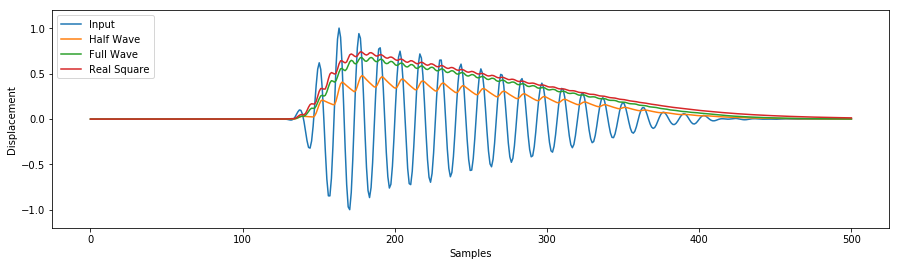

In [6]:
frequency = 750 # Hz
attack = 2      # ms
release = 5     # ms

# Generate the input signal
signalBuffer = sineWaveDecay(frequency)

# Halfwave
_, halfwaveBuffer = halfWaveEnvelope(signalBuffer, attack, release)

# Fullwave
_, fullwaveBuffer = fullWaveEnvelope(signalBuffer, attack, release)

# Real square law
_, realSquareLawBuffer = realSquareLawEnvelope(signalBuffer, attack, release)

plt.figure(figsize=(15, 4))

signalPlot = plt.plot(SAMPLE_RANGE, signalBuffer, label="Input")
halfWavePlot = plt.plot(SAMPLE_RANGE, halfwaveBuffer, label="Half Wave")
fullWavePlot = plt.plot(SAMPLE_RANGE, fullwaveBuffer, label="Full Wave")
realSquarePlot = plt.plot(SAMPLE_RANGE, realSquareLawBuffer, label="Real Square")

plt.ylim(bottom=-Y_LIMIT, top=Y_LIMIT)
plt.xlabel("Samples")
plt.ylabel("Displacement")
plt.legend(loc='upper left')

plt.show()

We can see that the real square law envelope follower is able to follow the amplitude of the input signal slightly better than the full wave design, and with a little less ripple.

Both of these designs though perform much better than the half wave follower, which has much more ripple and reacts more slowly, causing it to be unable to follow the input signal closely.


## Further Reading
Below are several resources that I found useful while researching this notebook. If you wish to read more about this topic, these may be good places to start.

[Envelope detector](https://en.wikipedia.org/wiki/Envelope_detector)  
[Digital Envelope Detection: The Good, the Bad, and the Ugly](https://www.dsprelated.com/showarticle/938.php)  
[Meaning of Hilbert Transform](https://dsp.stackexchange.com/questions/25845/meaning-of-hilbert-transform)  
[Envelope detector](http://www.musicdsp.org/en/latest/Analysis/97-envelope-detector.html)  
[Envelope Controlled Filters](http://elliott-randall.com/2011/06/envelope-controlled-filters/)  
[Auto-wah](https://en.wikipedia.org/wiki/Auto-wah)  
[Amplitude Modulation](https://user.eng.umd.edu/~tretter/commlab/c6713slides/ch5.pdf)